# Multiple Linear Regression from Scratch

### Step 1: Data Preprocessing & Split

Following the assignment brief, we first remove identifier columns if they exist, handle any missing values, separate features (\(X\)) from the target (\(y\)), and finally standardize each feature before splitting into training and test subsets.  Standardization keeps gradient descent stable by giving each column zero mean and unit variance.

Equation (Eq. 1) — feature standardization:

$$
Z = \frac{X - \mu}{\sigma} \tag{Eq. 1}
$$

where \(\mu\) and \(\sigma\) are the mean and standard deviation computed on the training set only.  (Code: preprocessing cell implements Eq. 1 via StandardScaler.fit_transform / transform.)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Load the concrete compressive strength dataset into a DataFrame
# (no equation; raw data load)
df = pd.read_csv('concrete_data.csv')

# 2) Drop identifier or redundant columns if they exist (assignment guideline)
identifier_cols = [
    col for col in df.columns
    if col.lower() in {'id', 'serial no', 'serial_no', 'serialno', 'unnamed: 0', 'unnamed:0'}
]
if identifier_cols:
    df = df.drop(columns=identifier_cols)

# 3) Handle missing values (dataset has none, but this keeps pipeline robust)
if df.isnull().any().any():
    df = df.dropna()

# 4) Separate features X (all but last column) and target y (last column)
# (Notation follows PDF: X, y)
X = df.iloc[:, :-1].values  # shape: (m, n)
y = df.iloc[:, -1].values   # shape: (m,)

# 5) Split into training/testing sets so model evaluation is on unseen data
#    (X_train, y_train) used for gradient descent; (X_test, y_test) kept for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) Standardize features: implements Eq. 1 (Z = (X - μ)/σ)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # computes μ, σ on training set and applies: Eq. 1
X_test = scaler.transform(X_test)        # applies same μ, σ to test set (avoid leakage)

# 7) Reshape targets to column vectors so matrix math matches the hypothesis Xθ + b
# (Code uses column-vector y to match matrix equations in the PDF)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Training data shape: (824, 8)
Test data shape: (206, 8)
Training target shape: (824, 1)
Test target shape: (206, 1)


### Step 2: Model Training

We initialize the parameter vector \(\boldsymbol{\theta} \in \mathbb{R}^{n}\) and the bias \(b\), then iteratively minimize the training loss using batch gradient descent.  Each epoch performs the following calculations (equations labeled to match the notebook code comments):

- **Hypothesis (forward pass) — Eq. 2:** \(\hat{\mathbf{y}} = X_{\text{train}} \boldsymbol{\theta} + b\)  (Code: `y_pred = X_train.dot(theta) + b` implements Eq. 2)

- **Mean Squared Error (MSE) loss — Eq. 3:**
  $$L(\boldsymbol{\theta}, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2 \tag{Eq. 3}$$
  (Code: `loss = np.mean(error ** 2)` implements Eq. 3)

- **Gradients — Eq. 4a / 4b:**
  $$\nabla_{\boldsymbol{\theta}} L = \frac{2}{m} X_{\text{train}}^{\top} (\hat{\mathbf{y}} - \mathbf{y}) \tag{Eq. 4a}$$
  $$\nabla_{b} L = \frac{2}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i) \tag{Eq. 4b}$$
  (Code: `grad_theta = (2 / m) * X_train.T.dot(error)` and `grad_b = (2 / m) * np.sum(error)` implement Eq. 4a and 4b)

- **Parameter update — Eq. 5:**
  $$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \alpha \nabla_{\boldsymbol{\theta}} L, \quad b \leftarrow b - \alpha \nabla_{b} L \tag{Eq. 5}$$
  (Code: `theta -= learning_rate * grad_theta` and `b -= learning_rate * grad_b` implement Eq. 5)

The loop continues until either the set number of iterations is reached or the loss converges to a small value.

In [21]:
import numpy as np

# Ensure inputs are numeric and have expected shapes/dtypes
X_train = np.asarray(X_train, dtype=np.float64)
X_test  = np.asarray(X_test, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64).reshape(-1, 1)
y_test  = np.asarray(y_test, dtype=np.float64).reshape(-1, 1)

# Basic shape checks
m, n = X_train.shape
assert y_train.shape[0] == m, f"Mismatched rows: X_train {X_train.shape}, y_train {y_train.shape}"

# Initialize parameters (θ small random, b = 0) per PDF
np.random.seed(42)
theta = np.random.normal(loc=0.0, scale=0.01, size=(n, 1))  # shape (n,1)
b = 0.0

# Hyper-parameters
learning_rate = 0.01
iterations = 1000
losses = []

# Training loop (batch gradient descent)
for i in range(iterations):
    # Eq. 2: Forward pass ŷ = X θ + b
    y_pred = X_train.dot(theta) + b  # implements Eq. 2

    # Error / residual vector (used in Eq. 3 and Eq. 4)
    error = y_pred - y_train  # shape (m,1)

    # Eq. 3: MSE loss L = (1/m) Σ (ŷ - y)^2
    loss = np.mean(error ** 2)  # implements Eq. 3
    losses.append(loss)

    # Eq. 4a: gradient w.r.t θ (2/m) X^T (ŷ - y)
    grad_theta = (2 / m) * X_train.T.dot(error)  # implements Eq. 4a
    # Eq. 4b: gradient w.r.t b (2/m) Σ (ŷ - y)
    grad_b = (2 / m) * np.sum(error)            # implements Eq. 4b

    # Eq. 5: parameter update θ ← θ − α ∇_θ L ; b ← b − α ∇_b L
    theta -= learning_rate * grad_theta  # implements Eq. 5
    b -= learning_rate * grad_b         # implements Eq. 5

    # Monitor (console output)
    if (i + 1) % 100 == 0:
        print(f'Iteration {i+1}/{iterations}, Loss: {loss:.4f}')

# Keep final theta and b for evaluation
print('Training complete.')

Iteration 100/1000, Loss: 145.2264
Iteration 200/1000, Loss: 116.9927
Iteration 300/1000, Loss: 114.9704
Iteration 400/1000, Loss: 114.0423
Iteration 500/1000, Loss: 113.4471
Iteration 600/1000, Loss: 113.0251
Iteration 700/1000, Loss: 112.7018
Iteration 800/1000, Loss: 112.4399
Iteration 900/1000, Loss: 112.2199
Iteration 1000/1000, Loss: 112.0309
Training complete.


### Step 3: Evaluation

With the learned \(\boldsymbol{\theta}\) and \(b\), we generate predictions on the held-out test set and compute the Mean Squared Error.  This implements the same loss formula used during training (Eq. 3) but evaluated on the test set:

$$\text{MSE}_{\text{test}} = \frac{1}{m_{\text{test}}} \sum_{i=1}^{m_{\text{test}}} (\hat{y}^{(\text{test})}_i - y^{(\text{test})}_i)^2 \tag{Eq. 6 (test)}$$

(Code: `y_pred_test = X_test.dot(theta) + b` implements hypothesis on test set; `mse = np.mean((y_pred_test - y_test) ** 2)` computes Eq. 6)

In [22]:
# Forward pass on the normalized test features (ŷ_test = X_test θ + b) — implements test hypothesis (Eq. 6)
y_pred_test = np.dot(X_test, theta) + b

# Compute test MSE using the same formula as during training (Eq. 6)
mse = np.mean((y_pred_test - y_test) ** 2)
print(f'Mean Squared Error on Test Set: {mse:.4f}')

Mean Squared Error on Test Set: 96.7179


### Step 4: Visualization

To verify convergence, we plot the loss curve across epochs.  A second plot compares predicted versus actual compressive strengths; points tightly clustered around the diagonal indicate good predictive performance.

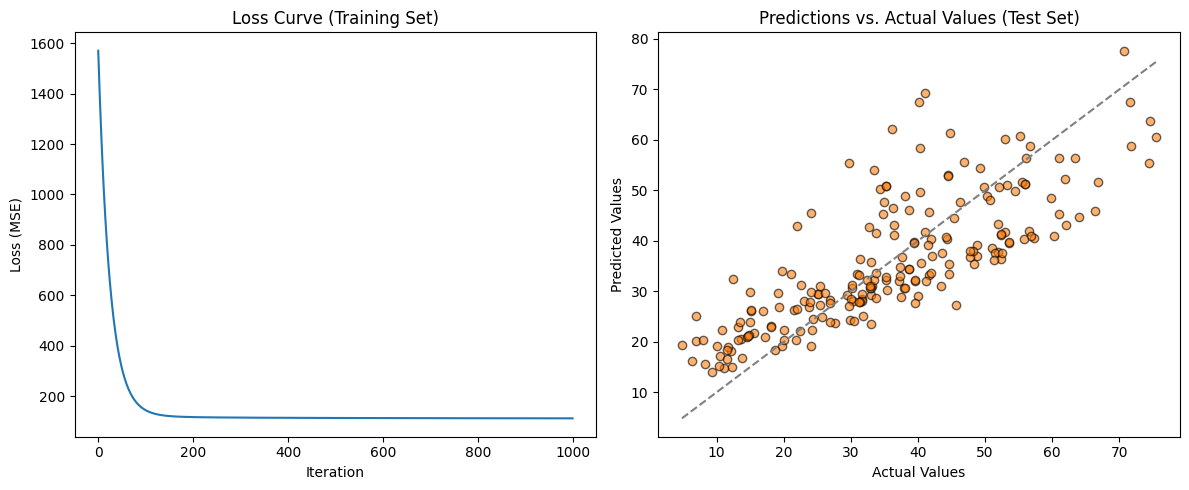

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# ----------------------------------------------------------------------------
# Plot 1: Training loss vs. iteration to monitor gradient descent convergence
# ----------------------------------------------------------------------------
plt.subplot(1, 2, 1)
plt.plot(losses, color='tab:blue')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve (Training Set)')

# ----------------------------------------------------------------------------
# Plot 2: Scatter plot of actual vs. predicted compressive strength on test set
# If predictions are perfect, points lie on the 45° line y = x.
# ----------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.scatter(y_test.ravel(), y_pred_test.ravel(), alpha=0.6, color='tab:orange', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values (Test Set)')

plt.tight_layout()
plt.show()

### Bonus: Hyper-parameter Tuning

We sweep over a small grid of learning rates \(\alpha\) and retrain the model from scratch for each value, recording the test-set MSE to identify the most effective step size for gradient descent.

In [19]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
best_mse = float('inf')
best_lr = None

for lr in learning_rates:
    print(f'Training with learning rate: {lr}')

    # Reinitialize parameters for a fair comparison at each learning rate
    np.random.seed(42)
    theta = np.random.randn(X_train.shape[1], 1)
    bias = 0.0
    iterations = 1000

    for _ in range(iterations):
        # Forward pass & residuals using current θ, b
        y_pred = np.dot(X_train, theta) + bias
        error = y_pred - y_train

        # Gradients and parameter updates with candidate learning rate
        grad_theta = (2 / len(X_train)) * np.dot(X_train.T, error)
        grad_bias = (2 / len(X_train)) * np.sum(error)
        theta -= lr * grad_theta
        bias -= lr * grad_bias

    # Evaluate current model on the test set
    y_pred_test = np.dot(X_test, theta) + bias
    mse = np.mean((y_pred_test - y_test) ** 2)
    print(f'MSE on Test Set: {mse:.4f}')

    if mse < best_mse:
        best_mse = mse
        best_lr = lr

print(f'Best learning rate: {best_lr} with MSE: {best_mse:.4f}')

Training with learning rate: 0.1
MSE on Test Set: 95.9697
Training with learning rate: 0.05
MSE on Test Set: 95.9471
Training with learning rate: 0.01
MSE on Test Set: 96.5267
Training with learning rate: 0.005
MSE on Test Set: 97.9148
Training with learning rate: 0.001
MSE on Test Set: 130.6094
Best learning rate: 0.05 with MSE: 95.9471
